# Notebook: Glottal Source, Harmonics, and Pitch

**EE519 — Speech Recognition & Processing for Multimedia**  
**Sudarsana Reddy Kadiri <skadiri@usc.edu>**  

**Lecture 3 Hands-on (Jupyter Notebook)**  
Focus: periodic excitation, F0/pitch, harmonics, spectral tilt.

---

## Learning goals
1. Connect **time-domain** waveforms to **frequency-domain** spectra (harmonics, resonances).
2. Understand the **source–filter** model: *source* (glottal or noise) → *filter* (vocal tract) → *speech output*.
3. Relate **F0** to pitch and **formants (F1/F2/F3)** to vowel identity.

## How to run
- Run cells top-to-bottom.
- If sliders do not appear, install **ipywidgets** (optional but recommended).

## Deliverables (for students)
- Answer short questions in the **🧠 Checkpoint** cells.
- Complete **✅ Mini-task** sections.

## Dependencies
- Required: `numpy`, `matplotlib`
- Recommended: `scipy` (filters/spectrograms), `ipywidgets` (interactive sliders)


# EE519 Lecture — Notebook 1: Glottal Source, Harmonics, and Pitch
This notebook is a hands-on companion for Lecture 3 (speech production + source–filter theory).

**You will:**
- Generate simple *glottal-source-like* periodic waveforms.
- Hear how **F0 (fundamental frequency)** relates to pitch.
- See **harmonics** in the spectrum and how they change with F0 and pulse shape.

### Terminology (quick)
- **Period**: time for one cycle; **F0** = 1/period.
- **Harmonics**: frequency components at integer multiples of F0.
- **Spectrum**: how energy is distributed across frequency.


In [11]:

# EE519 Lecture Hands-on Notebooks
# Common setup utilities (used in this notebook)

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Optional dependencies
try:
    import scipy
    from scipy import signal
except Exception as e:
    scipy = None
    signal = None
    print("Warning: scipy is not available. Some filtering demos will be limited.", e)

try:
    import ipywidgets as widgets
    from ipywidgets import interact
except Exception as e:
    widgets = None
    interact = None
    print("Warning: ipywidgets is not available. Sliders will not render.", e)

FS = 16000  # sample rate (Hz) — keep small for fast interactive demos

def db(x, eps=1e-12):
    "Convert magnitude to dB safely."
    x = np.maximum(np.asarray(x), eps)
    return 20*np.log10(x)

def plot_time(x, fs=FS, title="Waveform", tlim=None):
    t = np.arange(len(x))/fs
    plt.figure(figsize=(10,3))
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    plt.grid(True, alpha=0.3)
    plt.show()

def spectrum(x, fs=FS, nfft=None, window=True):
    "Return frequency (Hz) and magnitude spectrum (linear) for x."
    x = np.asarray(x)
    if nfft is None:
        nfft = int(2**np.ceil(np.log2(max(1024, len(x)))))
    w = np.hanning(len(x)) if window else np.ones(len(x))
    X = np.fft.rfft(x*w, n=nfft)
    f = np.fft.rfftfreq(nfft, 1/fs)
    mag = np.abs(X)
    return f, mag

def plot_spectrum(x, fs=FS, title="Magnitude Spectrum (dB)", fmax=4000, nfft=1024):
    f, mag = spectrum(x, fs=fs, nfft=nfft)
    plt.figure(figsize=(10,3))
    plt.plot(f, db(mag))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title)
    plt.xlim([0, fmax])
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_response(b, a, fs=FS, title="Filter Frequency Response", fmax=5000):
    if signal is None:
        print("scipy.signal unavailable; cannot compute frequency response.")
        return
    w, h = signal.freqz(b, a, worN=2048, fs=fs)
    plt.figure(figsize=(10,3))
    plt.plot(w, db(np.abs(h)))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title)
    plt.xlim([0, fmax])
    plt.grid(True, alpha=0.3)
    plt.show()

def spectrogram(x, fs=FS, title="Spectrogram", nperseg=512, noverlap=384, fmax=5000):
    if signal is None:
        print("scipy.signal unavailable; cannot compute spectrogram.")
        return
    f, t, Sxx = signal.spectrogram(x, fs=fs, window="hann",
                                   nperseg=nperseg, noverlap=noverlap,
                                   scaling="spectrum", mode="magnitude")
    plt.figure(figsize=(10,3.5))
    plt.pcolormesh(t, f, db(Sxx), shading="gouraud")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title(title)
    plt.ylim([0, fmax])
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

def normalize_audio(x, peak=0.95):
    x = np.asarray(x, dtype=float)
    m = np.max(np.abs(x)) + 1e-12
    return (peak/m) * x

# --- Source models ---

def impulse_train(f0=120, dur=1.0, fs=FS):
    "Impulse train at f0 Hz."
    n = int(dur*fs)
    x = np.zeros(n)
    period = int(round(fs/f0))
    x[::period] = 1.0
    return x

def rosenberg_glottal_pulse(f0=120, dur=1.0, fs=FS, open_quotient=0.6, return_quotient=0.2):
    """
    Simple Rosenberg glottal pulse train:
      - opening phase: half cosine up
      - closing phase: half cosine down
      - rest: zero
    open_quotient: fraction of period for open phase (0-1)
    return_quotient: fraction of period for closing phase (0-1), within open phase
    """
    n = int(dur*fs)
    period = int(round(fs/f0))
    x = np.zeros(n)

    To = int(np.clip(open_quotient, 0.05, 0.95) * period)
    Tc = int(np.clip(return_quotient, 0.05, 0.95) * To)
    Ta = To - Tc  # opening part length

    pulse = np.zeros(period)
    if Ta > 1:
        t = np.arange(Ta)
        pulse[:Ta] = 0.5*(1 - np.cos(np.pi * t/(Ta-1)))  # rises 0->1
    if Tc > 1:
        t = np.arange(Tc)
        pulse[Ta:Ta+Tc] = 0.5*(1 + np.cos(np.pi * t/(Tc-1)))  # falls 1->0

    for i in range(0, n, period):
        seg = min(period, n-i)
        x[i:i+seg] = pulse[:seg]
    return x

def add_spectral_tilt(x, fs=FS, tilt_db_per_oct=-12):
    """
    Approximate spectral tilt by a 1st-order lowpass (pedagogical).
    More negative tilt -> lower cutoff (heuristic).
    """
    if signal is None:
        return x
    cutoff = np.clip(3000 + 80*tilt_db_per_oct, 300, 6000)
    b, a = signal.butter(1, cutoff/(fs/2), btype="low")
    return signal.lfilter(b, a, x)

# --- Vocal tract filter models ---

def formant_cascade(formants_hz=(700, 1100, 2500), bandwidths_hz=(80, 90, 120), fs=FS, gain=1.0):
    """
    Create an all-pole cascade filter for given formants (2nd-order resonators).
    Returns (b, a) IIR filter coefficients.
    """
    if signal is None:
        raise RuntimeError("scipy.signal required for IIR design.")
    b = np.array([gain])
    a = np.array([1.0])
    for F, B in zip(formants_hz, bandwidths_hz):
        r = np.exp(-np.pi * B / fs)
        theta = 2*np.pi*F/fs
        a_sec = np.array([1.0, -2*r*np.cos(theta), r**2])
        b_sec = np.array([1.0])  # all-pole section
        b = np.convolve(b, b_sec)
        a = np.convolve(a, a_sec)
    return b, a

def quarter_wave_formants(tube_length_cm=17.0, n_formants=4, c=35000.0):
    """
    Uniform tube, one end closed (glottis), one end open (lips):
    formants at (2k-1)*c/(4L) for k=1..n.
    c in cm/s, L in cm.
    """
    L = tube_length_cm
    ks = np.arange(1, n_formants+1)
    return (2*ks - 1) * c / (4*L)

def mix(a, b, alpha=0.5):
    "alpha=1 -> a, alpha=0 -> b"
    return alpha*np.asarray(a) + (1-alpha)*np.asarray(b)


> *What single thing does a pure sinusoid tell us about frequency?* why speech is not a sinusoid.

## A1. Warm-up: a pure sinusoid
A single sinusoid has exactly one frequency component. Real speech sources are not pure sinusoids—they are closer to **complex periodic waveforms**, which contain harmonics.

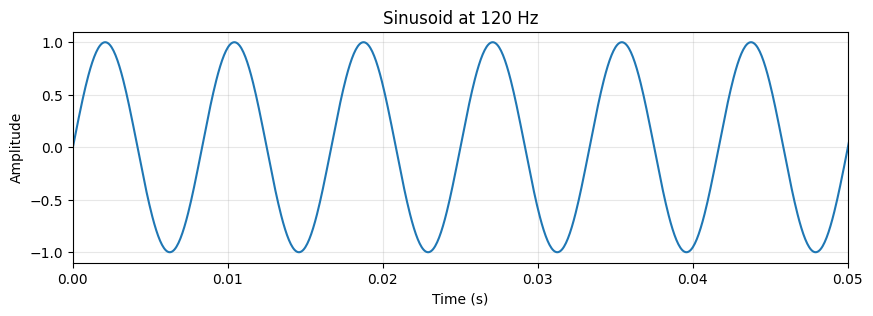

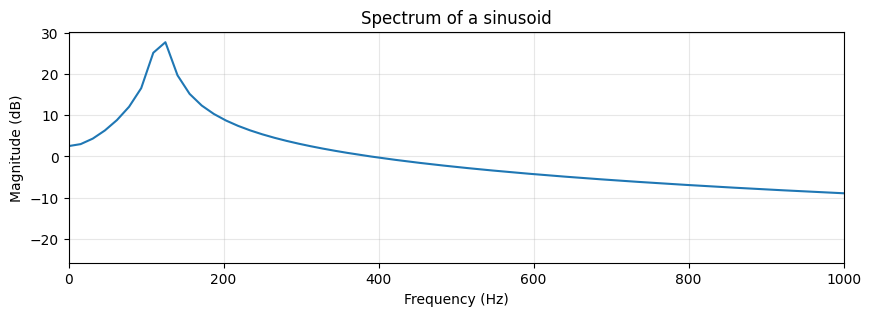

In [12]:

dur = 0.5
f = 120
t = np.arange(int(dur*FS))/FS
x = np.sin(2*np.pi*f*t)

plot_time(x, title=f"Sinusoid at {f} Hz", tlim=(0, 0.05))
plot_spectrum(x, title="Spectrum of a sinusoid", fmax=1000)
display(Audio(normalize_audio(x), rate=FS))


> **Instructor notes:** Emphasize: impulse train = evenly spaced harmonics. Point out harmonic spacing equals F0.

## A2. Impulse train source (toy model)
An impulse train is a classic *toy* source: a perfectly periodic series of impulses.

**Key idea:** in the frequency domain, an impulse train becomes a set of equally spaced lines at multiples of F0.

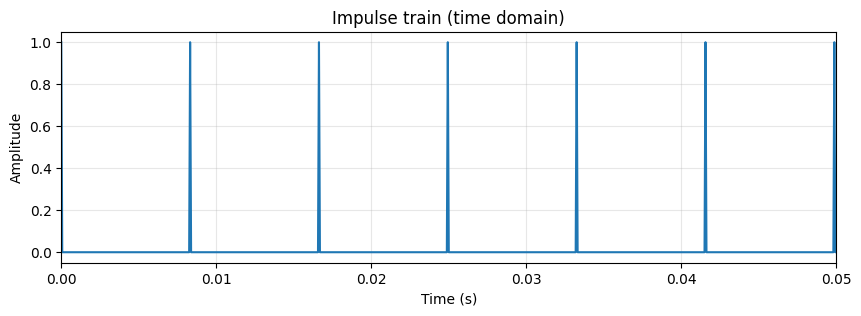

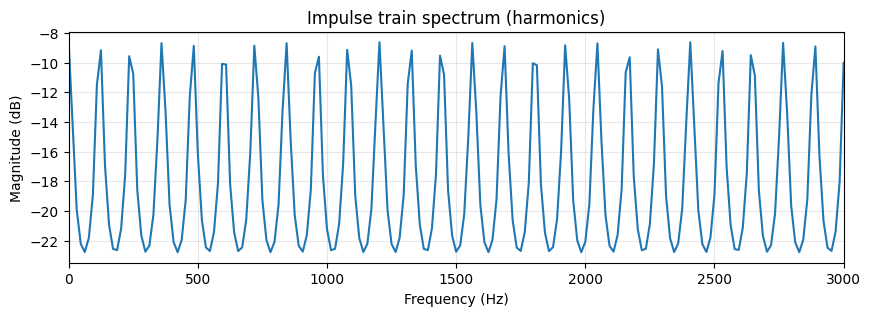

In [13]:

x = impulse_train(f0=120, dur=0.5)
plot_time(x, title="Impulse train (time domain)", tlim=(0, 0.05))
plot_spectrum(x, title="Impulse train spectrum (harmonics)", fmax=3000)


> **Instructor notes:** Connect pulse shape to spectral tilt: sharper closures produce more high-frequency energy.

## A3. Rosenberg glottal pulse train (more speech-like)
A simple glottal pulse model: rise (opening), fall (closing), then rest.

**Control knobs:**
- `f0`: fundamental frequency
- `open_quotient`: how long the glottis stays open in each period
- `return_quotient`: how quickly it closes within the open phase


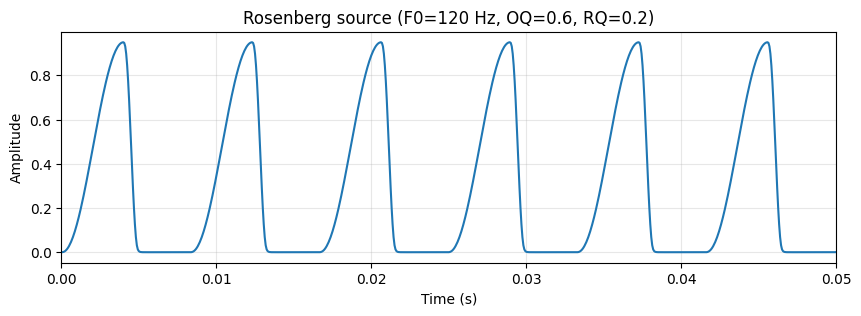

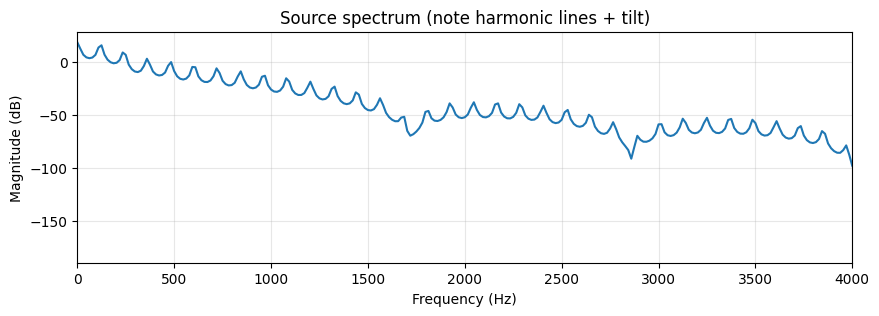

interactive(children=(IntSlider(value=120, description='f0', max=300, min=60, step=5), FloatSlider(value=0.6, …

In [14]:

def demo_rosenberg(f0=120, open_quotient=0.6, return_quotient=0.2, dur=0.7, tilt=-12):
    x = rosenberg_glottal_pulse(f0=f0, dur=dur, open_quotient=open_quotient, return_quotient=return_quotient)
    x = add_spectral_tilt(x, tilt_db_per_oct=tilt)
    x = normalize_audio(x)
    plot_time(x, title=f"Rosenberg source (F0={f0} Hz, OQ={open_quotient}, RQ={return_quotient})", tlim=(0, 0.05))
    plot_spectrum(x, title="Source spectrum (note harmonic lines + tilt)", fmax=4000)
    display(Audio(x, rate=FS))

if interact is not None:
    interact(demo_rosenberg,
             f0=widgets.IntSlider(min=60, max=300, step=5, value=120),
             open_quotient=widgets.FloatSlider(min=0.2, max=0.9, step=0.05, value=0.6),
             return_quotient=widgets.FloatSlider(min=0.1, max=0.9, step=0.05, value=0.2),
             dur=widgets.FloatSlider(min=0.3, max=1.0, step=0.1, value=0.7),
             tilt=widgets.IntSlider(min=-24, max=-3, step=1, value=-12)
            )
else:
    demo_rosenberg()


## A4. Harmonic spacing and F0
When F0 increases, harmonic spacing increases.

### Exercise
1. Set F0 = 100 Hz and note harmonic spacing.
2. Set F0 = 200 Hz and note the new spacing.
3. In **one sentence**, describe the relationship.


## 🧠 Checkpoint
- **Q1:** If F0 doubles, what happens to harmonic spacing?
- **Q2:** Why does a more ‘peaky’ pulse often increase high-frequency energy?
- **Q3:** What is one reason two speakers can produce the same vowel with different pitch?

**Your answers:**

- Q1:
- Q2:
- Q3:


## A5 Voiced vs. noise source
Voicing is periodic. Frication is closer to noise (aperiodic). Compare their spectra.

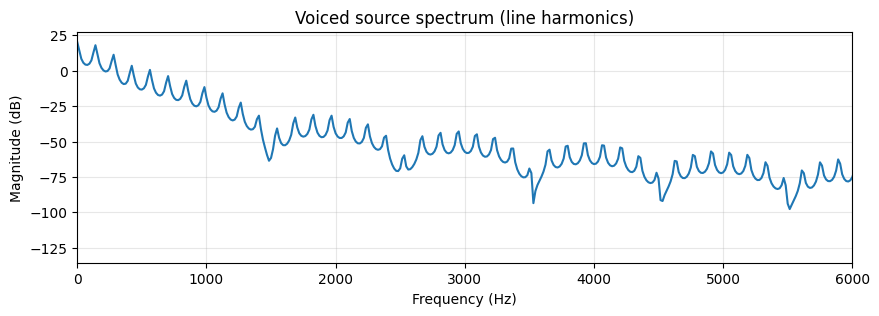

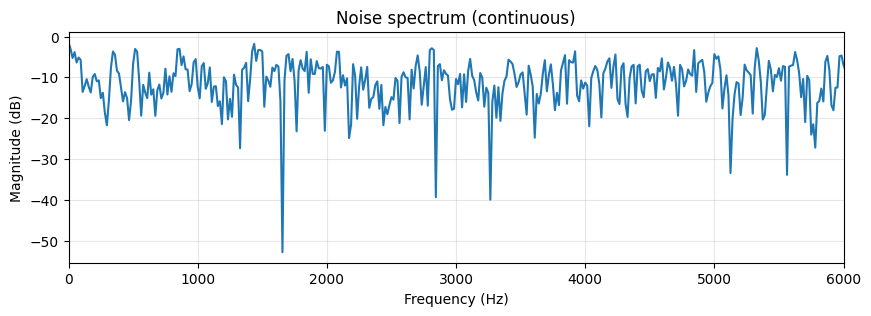

Voiced:


Noise:


In [15]:

rng = np.random.default_rng(0)
dur = 0.6

voiced = rosenberg_glottal_pulse(f0=140, dur=dur, open_quotient=0.6, return_quotient=0.25)
noise = rng.standard_normal(int(dur*FS))

voiced = normalize_audio(voiced)
noise = normalize_audio(noise)

plot_spectrum(voiced, title="Voiced source spectrum (line harmonics)", fmax=6000)
plot_spectrum(noise, title="Noise spectrum (continuous)", fmax=6000)

print("Voiced:")
display(Audio(voiced, rate=FS))
print("Noise:")
display(Audio(noise, rate=FS))


## A6 Mini-checkpoint questions
- Why do periodic signals create *line spectra*?
- How does changing pulse shape affect spectral tilt?
- Why might two speakers have similar vowels but different pitch?


## ✅ Mini-task 
Choose **two** different pulse shapes (vary `open_quotient` and `return_quotient`) at the **same F0**.
1. Screenshot/record the *source spectrum* for both.
2. In 2–3 sentences, describe how the spectrum changed and why.

**Your response:**



## What did you learn?
- 